# Setup Code

In [1]:
import torch.nn as nn
import torch.nn.functional as F 
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import itertools

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import layers
import solvers
import nets

from params import *
from config import *

import utils

%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

utils.print_info()

params = SPRITESParameters()
img_size = params.img_size
img_channel = params.img_channel

0.4.0
using device: cuda
data type: torch.float32
VERBOSE== False


# Data Loading

In [2]:
dataloader = utils.dataLoader('SPRITES')

# Network Architecture

# Step1: train s encoder and classifier
the encoder+classifier structure has achieved 97% accuracy on MNIST

In [3]:
#test S encoder
nets.test_Encoder(nets.S_Encoder(params),params)
#test z encoder
nets.test_Encoder(nets.Z_Encoder(params),params)
#test s classifier
nets.test_classifier(nets.S_Classifier(params),params)
#test decoder
nets.test_Decoder(nets.SZ_Decoder(params),params)

torch.Size([64, 32])

torch.Size([64, 128])

torch.Size([64, 336])

torch.Size([64, 3, 32, 32])



332
59


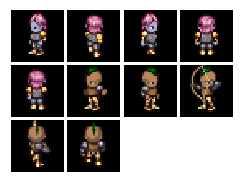

In [4]:
dataloader.show_imgs()

In [5]:
s_enc = nets.S_Encoder(params)
s_classifier = nets.S_Classifier(params)
classifier_solver = solvers.ClassifierSolver(s_enc, s_classifier, dataloader, params)

In [6]:
classifier_solver.train(100)
classifier_solver.test(mode = 'test')

Checking accuracy on test set2, acc=0.96
Got 4776 / 5000 correct (95.52)


0.9552

In [287]:
#new_s_enc = nets.S_Encoder(params)
utils.save_models(s_enc,mode='param',mode_param = '96%')
utils.load_models(s_enc,path=var_save_path,suffix='96%')

In [288]:
classifier_solver.test(mode = 'test')

Checking accuracy on test set
Got 4809 / 5000 correct (96.18)


0.9618

In [113]:
dataloader.imgs.shape

(1024, 3072)

torch.Size([8, 3, 60, 60])
tensor([ 134,  331,   82,  134,   47,  134,  331,  134], device='cuda:0')


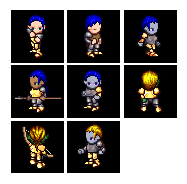

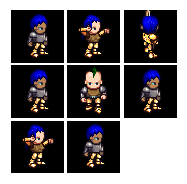

In [81]:
num=8
#ori_imgs=torch.stack(dataloader.img_grouped[200][0:num])
ori_imgs = torch.tensor(dataloader.imgs[0:num])
test_imgs = ori_imgs.view(num,img_channel,img_size,img_size)
print(test_imgs.shape)
predicted = classifier_solver.predict(test_imgs)
print(predicted)
clss = list(predicted.cpu().numpy())
utils.show_images(ori_imgs,params)
dataloader.show_imgs(clss,show_num=1)

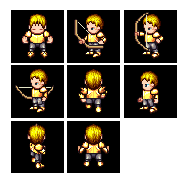

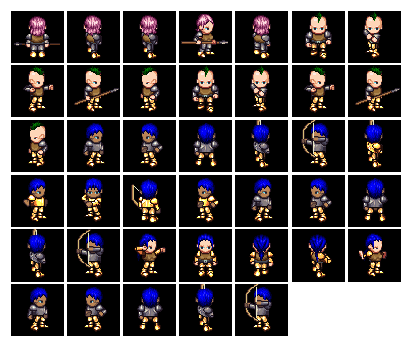

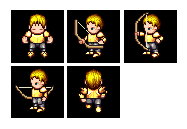

# Step two, train disentangle-adversariel network

In [300]:
def get_DisAdvSolver(loading=False,name = ''):
    if loading==False:
        z_enc = nets.Z_Encoder(params)
        z_adv = nets.Z_AdvLayer(params)
        sz_dec= nets.SZ_Decoder(params)
        s_encoder = s_enc
        solver = solvers.DisAdvSolver(s_encoder, z_enc, sz_dec, z_adv, dataloader, params,model_name='trueTest',saving_while_training=True)
    else:
        solver = solvers.DisAdvSolver(dloader=dataloader,params=params, loading=True,loadSuffix=name,model_name='trueTest',saving_while_training=True)
    return solver

In [341]:
solver = get_DisAdvSolver(loading=False, name = 'firstTry')

In [ ]:
solver.train(10000000)

z_latent_norm: tensor(4.9603, device='cuda:0')


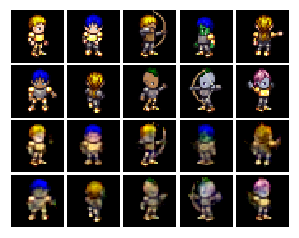

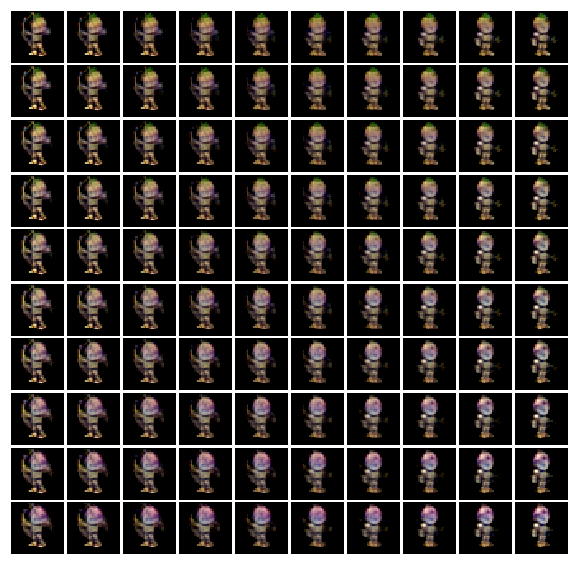

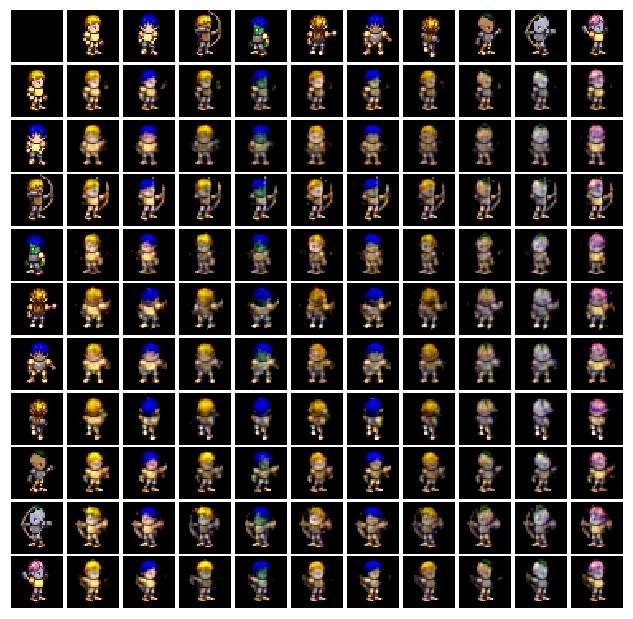

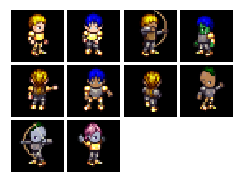

In [369]:
solver.reconSolver.params = SPRITESParameters()
solver.reconSolver.test()
solver.show_interpolated(10)
solver.show_switch_latent(10)

In [370]:
solver.load_model(suffix='_num570000')
solver.it_count = 570001
solver.params = SPRITESParameters()

In [371]:
solver.saving_while_training = True